In [2]:
import os
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from skimage.io import ImageCollection, imsave
from skimage.color import rgb2hsv, rgb2gray, gray2rgb
from skimage.transform import resize, warp, SimilarityTransform, AffineTransform, ProjectiveTransform
from skimage.feature import (ORB, match_descriptors, corner_harris, corner_peaks, BRIEF,)
from skimage.measure import ransac
from skimage.util import img_as_float
from numpy.random import randint
from skimage.data import imread

from skimage.measure import label
from skimage.graph import route_through_array
from sklearn.feature_extraction import image
from subprocess import Popen, PIPE
from multiprocessing import Pool, freeze_support, cpu_count
import itertools
from scipy.ndimage import rotate
import math
%matplotlib inline
path_to_enblend = '/Users/jhansen/Applications/enblend-enfuse-4.0-mac/enblend'
tmp_out = '/tmp/out.png'
tmp_base = '/tmp/base.png'
tmp_img = '/tmp/img.png'
data_dir = '../data/jpg/'



from shutil import copyfile
import subprocess
from subprocess import Popen, PIPE
from multiprocessing import Pool, freeze_support, cpu_count
import matplotlib.pyplot as plt
import itertools
import os
from glob import glob
import numpy as np
import argparse
import sys

from itertools import islice
import cv2
from copy import copy, deepcopy
from scipy.ndimage import rotate

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
import config
import math

%autoreload 2


from skimage.io import imread, imsave
from skimage.color import gray2rgb, rgb2gray
from skimage.feature import match_descriptors
from skimage.measure import ransac
from skimage.transform import warp, SimilarityTransform, AffineTransform, ProjectiveTransform
from skimage import img_as_float, img_as_ubyte
%matplotlib inline
rsn = 4
import mosaic as m
import pandas as pd

ERROR: Line magic function `%autoreload` not found.


In [32]:

def plot_matches(ax, image1, image2, keypoints1, keypoints2, matches, title='',
                 keypoints_color='b', matches_color=None, only_matches=False):
    """Plot matched features.
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Matches and image are drawn in this ax.
    image1 : (N, M [, 3]) array
        First grayscale or color image.
    image2 : (N, M [, 3]) array
        Second grayscale or color image.
    keypoints1 : (K1, 2) array
        First keypoint coordinates as ``(row, col)``.
    keypoints2 : (K2, 2) array
        Second keypoint coordinates as ``(row, col)``.
    matches : (Q, 2) array
        Indices of corresponding matches in first and second set of
        descriptors, where ``matches[:, 0]`` denote the indices in the first
        and ``matches[:, 1]`` the indices in the second set of descriptors.
    keypoints_color : matplotlib color, optional
        Color for keypoint locations.
    matches_color : matplotlib color, optional
        Color for lines which connect keypoint matches. By default the
        color is chosen randomly.
    only_matches : bool, optional
        Whether to only plot matches and not plot the keypoint locations.
    """

    image1 = img_as_float(image1)
    image2 = img_as_float(image2)

    new_shape1 = list(image1.shape)
    new_shape2 = list(image2.shape)

    if image1.shape[0] < image2.shape[0]:
        new_shape1[0] = image2.shape[0]
    elif image1.shape[0] > image2.shape[0]:
        new_shape2[0] = image1.shape[0]

    if image1.shape[1] < image2.shape[1]:
        new_shape1[1] = image2.shape[1]
    elif image1.shape[1] > image2.shape[1]:
        new_shape2[1] = image1.shape[1]

    if new_shape1 != image1.shape:
        new_image1 = np.zeros(new_shape1, dtype=image1.dtype)
        new_image1[:image1.shape[0], :image1.shape[1]] = image1
        image1 = new_image1

    if new_shape2 != image2.shape:
        new_image2 = np.zeros(new_shape2, dtype=image2.dtype)
        new_image2[:image2.shape[0], :image2.shape[1]] = image2
        image2 = new_image2

    image = np.concatenate([image1, image2], axis=1)

    offset = image1.shape

    if not only_matches:
        ax.scatter(keypoints1[:, 1], keypoints1[:, 0],
                   facecolors='none', edgecolors=keypoints_color)
        ax.scatter(keypoints2[:, 1] + offset[1], keypoints2[:, 0],
                   facecolors='none', edgecolors=keypoints_color)

    ax.imshow(image, interpolation='nearest', cmap='gray')
    ax.axis((0, 2 * offset[1], offset[0], 0))
    ax.set_title(title)

    for i in range(matches.shape[0]):
        idx1 = matches[i, 0]
        idx2 = matches[i, 1]

        if matches_color is None:
            color = np.random.rand(3, 1)
        else:
            color = matches_color

        ax.plot((keypoints1[idx1, 1], keypoints2[idx2, 1] + offset[1]),
                (keypoints1[idx1, 0], keypoints2[idx2, 0]),
                '-', color=color)



In [ ]:
run='texture'
test_imgs = {'texture':['dsc04743.jpg', 'dsc04744.jpg'], 
            'minimal':['dsc02820.jpg', 'dsc02821.jpg']}

img1o = imread(test_imgs[run][0])[0]#[:,:,2]
img2o = imread(test_imgs[run][1])[0]#[:,:,2]


In [ ]:
img1o.shape

In [ ]:
num_keypoints = 100

In [ ]:
img1 = resize(rgb2gray(img1o), (400,600))

ph = -img1.shape[0]
pw = -img1.shape[1]
ftype = 'ORB'


imgt = img1 
img45 = rotate(imgt, 45)
img90 = rotate(imgt, 90)
img180 = rotate(imgt, 180)

descriptor_extractor = ORB(n_keypoints=num_keypoints)

descriptor_extractor.detect_and_extract(imgt)
keypoints = descriptor_extractor.keypoints
descriptors = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(imgt)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img45)
keypoints45 = descriptor_extractor.keypoints
descriptors45 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img90)
keypoints90 = descriptor_extractor.keypoints
descriptors90 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img180)
keypoints180 = descriptor_extractor.keypoints
descriptors180 = descriptor_extractor.descriptors


if True:
    matches = match_descriptors(descriptors, descriptors1, cross_check=True)
    matches45 = match_descriptors(descriptors, descriptors45, cross_check=True)
    matches90 = match_descriptors(descriptors, descriptors90, cross_check=True)
    matches180 = match_descriptors(descriptors, descriptors180, cross_check=True)
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(4,14))

    plt.gray()
    # Select keypoints from 
    #   * source (image to be registered)
    #   * target (reference image): 
    src = keypoints[matches[:, 0]][:, ::-1]
    dst = keypoints1[matches[:, 1]][:, ::-1]
    
    model_robust, inliers = ransac((src, dst), AffineTransform,
                                       min_samples=4, residual_threshold=1, max_trials=300, 
                                      stop_probability=.99)

    
    
    src45 = keypoints[matches45[:, 0]][:, ::-1]
    dst45 = keypoints45[matches45[:, 1]][:, ::-1]

    model_robust45, inliers45 = ransac((src45, dst45), AffineTransform,
                                       min_samples=4, residual_threshold=1, max_trials=300, 
                                      stop_probability=.99)

    src90 = keypoints[matches90[:, 0]][:, ::-1]
    dst90 = keypoints90[matches90[:, 1]][:, ::-1]

    model_robust90, inliers90 = ransac((src90, dst90), AffineTransform,
                                       min_samples=4, residual_threshold=.5, max_trials=300, 
                                      stop_probability=.99)
    
    src180 = keypoints[matches180[:, 0]][:, ::-1]
    dst180 = keypoints90[matches180[:, 1]][:, ::-1]

    model_robust180, inliers180 = ransac((src180, dst180), AffineTransform,
                                       min_samples=4, residual_threshold=.5, max_trials=300, 
                                      stop_probability=.99)
    
    ransac_matches = matches[inliers]
    ransac_matches45 = matches45[inliers45]
    ransac_matches90 = matches90[inliers90]
    ransac_matches180 = matches180[inliers180]
    prec = round(ransac_matches.shape[0]/float(matches.shape[0]), 2)
    prec45 = round(ransac_matches45.shape[0]/float(matches45.shape[0]), 2)
    prec90 = round(ransac_matches90.shape[0]/float(matches90.shape[0]), 2)
    prec180 = round(ransac_matches180.shape[0]/float(matches180.shape[0]), 2)
    print("inliers", inliers45.shape, 'matches', matches45.shape)
    print(matches45.shape[0], prec45)
    print(matches90.shape[0], prec90)
    print(matches180.shape[0], prec180)

    plot_matches(ax[0], imgt, imgt, keypoints, keypoints1, 
                 ransac_matches, 'No Rotation: 0 Degrees')#, Keypoints: %s \n Matches: %s, Precision: %02.02f'%(keypoints.shape[0], matches.shape[0], prec))

    plot_matches(ax[1], imgt, img45, keypoints, keypoints45,
                 ransac_matches45, 'Rotation: 45 degrees')#, Keypoints: %s \n Matches: %s, Precision: %02.02f'%(keypoints45.shape[0], matches45.shape[0], prec45))
    #ax[0].axis('off')

    plot_matches(ax[2], imgt, img90, keypoints, keypoints90, 
                 ransac_matches90, 'Rotation: 90 degrees')#, Keypoints: %s \n Matches: %s, Precision: %02.02f'%(keypoints90.shape[0], matches90.shape[0], prec90))
    #ax[1].axis('off')
    

    plot_matches(ax[3], imgt, img180, keypoints, keypoints180, 
                 ransac_matches180, 'Rotation: 180 degrees')#, Keypoints: %s \n Matches: %s, Precision: %02.02f'%(keypoints180.shape[0], matches180.shape[0], prec180))
    #ax[2].axis('off')
    
    
    #plt.setp([a.get_xticklabels() for a in ax[0, :]], visible=False)
    #plt.setp([a.get_yticklabels() for a in ax[0, :]], visible=False)
    #plt.setp([a.get_xticklabels() for a in ax[1, :]], visible=False)
    #plt.setp([a.get_yticklabels() for a in ax[1, :]], visible=False)
    
    plt.show()

In [ ]:
matches45.shape

In [ ]:



#img45 = rotate(imgt, 45).astype(np.uint8)
#img90 = rotate(imgt, 90).astype(np.uint8)
#img180 = rotate(imgt, 180).astype(np.uint8)


sift = cv2.SIFT(4000)#

orb = cv2.ORB()
surf = cv2.SURF()
brisk = cv2.BRISK()
orb = cv2.ORB()

iname = 'dsc02821s.jpg'

rgb, k, d = m.loadImage(iname, sift)
print(d)
plt.imshow(rgb)

In [ ]:
rgb.shape

In [ ]:
model_robust, inliers, accuracy = match_from_to(k, d, bk, bd, self.matcher)
logging.info("match accuracy: %s for base %s with %s" %(accuracy, os.path.basename(bn), 
                                                        os.path.basename(name)))
print("accuracy", accuracy)
if accuracy > min_accuracy:
    models.append(model_robust)
    iis.append(rgb)
    tcorners = model_robust(base_corners)
    match_names.append(name)
    corners = np.vstack((corners, tcorners))
else:
    logging.info("Not able to match with Base:%s %d, Img: %s %d keypoints" %(os.path.basename(bn),
                                                                             bk.shape[0],
                                                                             os.path.basename(name), 
                                                                             k.shape[0]))

if len(models):

offset, output_shape = find_corners(corners)
lbrgb = img_as_float(brgb)
brgb_warped = warp_img(lbrgb, offset.inverse, output_shape)

if brgb_warped is None:
    logger.error("Unable to warp base img %s" %os.path.basename(bn))
else:
    oname = os.path.join(self.outpath, 'RUN%03d_MATCH%03d.%s' %(ROUND_NUM, CHUNK_NUM, self.out_ftype))
    tnames = []
    for xxv, (model, i, n) in enumerate(zip(models, iis, match_names)):
        ## Translate base into place
        tname = '/tmp/timg_%02d.png' %xxv
        logging.debug("writing tmp %s to match with bn %s as %s" %(os.path.basename(n), os.path.basename(bn), tname))
        transform = (model + offset).inverse
        rgb_warped = warp_img(i, transform, output_shape)
        if rgb_warped is None:
            logger.error("Base warp: Unable to warp img %s" %os.path.basename(n))
        else:
            # successful warp
            #plt.imsave(tname, rgb_warped)
            cv2.imwrite(tname, img_as_ubyte(rgb_warped))

            tnames.append(tname)


    if not len(tnames):
        logger.info("Not able to match %s images to %s" %(len(chunk), os.path.basename(n)))
    else:
        bname = '/tmp/bimg.png'
        #plt.imsave(bname, brgb_warped)
        cv2.imwrite(bname, img_as_ubyte(brgb_warped))
        nbrgb_warped = img_as_ubyte(deepcopy(brgb_warped))
        nbrgb_warped[nbrgb_warped==0] = 120
        ulbrgb = img_as_ubyte(brgb_warped)
              

In [ ]:
mosaic2imgs(imgt, img2, sift)
#plt.imshow(cimg)

In [ ]:
%timeit -r 10 mosaic2imgs(imgt, img2, surf)

In [ ]:
%timeit -r 10 mosaic2imgs(imgt, img2, brisk)

In [ ]:
%timeit -r 10 mosaic2imgs(imgt, img2, orb)

In [10]:
from skimage.feature.util import _mask_border_keypoints, DescriptorExtractor
    
def _zern_loop(image, descriptors, keypoints, pos0, pos1):
    for p in range(pos0.shape[0]):
        pr0 = pos0[p, 0]
        pc0 = pos0[p, 1]
        pr1 = pos1[p, 0]
        pc1 = pos1[p, 1]
        for k in range(keypoints.shape[0]):
            kr = keypoints[k, 0]
            kc = keypoints[k, 1]
            if image[kr + pr0, kc + pc0] < image[kr + pr1, kc + pc1]:
                descriptors[k, p] = True  

class zernike(DescriptorExtractor):
    
    def __init__(self, descriptor_size=256, patch_size=49,
                  sigma=1, sample_seed=1):
        self.descriptor_size = descriptor_size
        self.patch_size = patch_size
        self.sigma = sigma
        self.sample_seed = sample_seed

        self.descriptors = None
        self.mask = None

        
                    
    def extract(self, image, keypoints):
        patch_size = self.patch_size
        desc_size = self.descriptor_size
        random = np.random.RandomState()
        random.seed(self.sample_seed)
        samples = (patch_size / 5.0) * random.randn(desc_size * 8)
        samples = np.array(samples, dtype=np.int32)
        samples = samples[(samples < (patch_size // 2))
                          & (samples > - (patch_size - 2) // 2)]

        pos1 = samples[:desc_size * 2].reshape(desc_size, 2)
        pos2 = samples[desc_size * 2:desc_size * 4].reshape(desc_size, 2)
        
        pos1 = np.ascontiguousarray(pos1)
        pos2 = np.ascontiguousarray(pos2)
        self.mask = _mask_border_keypoints(image.shape, keypoints,
                                           patch_size // 2)
        keypoints = np.array(keypoints[self.mask, :], dtype=np.intp,
                             order='C', copy=False)
        self.descriptors = np.zeros((keypoints.shape[0], desc_size),
                                    dtype=bool, order='C')
        
        _zern_loop(image, self.descriptors.view(np.uint8), keypoints,
                    pos1, pos2)


In [14]:
zz = zernike()
img = cv2.cvtColor(cv2.imread('dji_0029s.jpg'), cv2.COLOR_BGR2GRAY)
#keypoints = corner_peaks(corner_harris(img1), min_distance=5)
kk = corner_peaks(corner_harris(img, method='eps', eps=.001, sigma=3), min_distance=5)
zz.extract(img, kk)
d = zz.descriptors
k = kk[zz.mask]
d.shape

(166, 256)

In [ ]:
import cv2

In [ ]:
from scipy import ndimage

#rotation angle in degree
rotated = ndimage.rotate(img1, 45)

In [6]:
num_kpts = 400
img = cv2.cvtColor(cv2.imread('dji_0029s.jpg'), cv2.COLOR_BGR2GRAY)

feat_detector = cv2.ORB(num_kpts)
#feat_detector=cv2.GridAdaptedFeatureDetector(feat_detector,50)
keypoints = feat_detector.detect(img,None)
freakExtractor = cv2.DescriptorExtractor_create('FREAK')
k,d= freakExtractor.compute(img, keypoints)


In [4]:
ls *.jpg

IMG_1765.jpg   IMG_1772.jpg   dsc02820.jpg*  dsc04743.jpg*  dsc05519.jpg*  i.jpg
IMG_1767.jpg   dji_0029.jpg   dsc02821.jpg*  dsc04744.jpg*  dsc05524.jpg*  img_mask.jpg
IMG_1771.jpg   dji_0029s.jpg  dsc02821s.jpg  dsc05518.jpg*  dsc05525.jpg*


AttributeError: 'module' object has no attribute 'BRIEF'

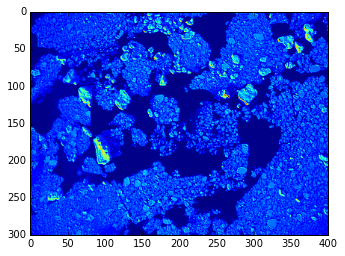

In [9]:
img1o = cv2.imread('dji_0029s.jpg')
img = cv2.resize(img1o, (400,300))

gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray)
sift = cv2.BRIEF()
kp, des = sift.detectAndCompute(gray,None)

img=cv2.drawKeypoints(gray,kp)
plt.imshow(img)
#cv2.imwrite('sift_keypoints.jpg',img)

((300, 400), (420, 480))


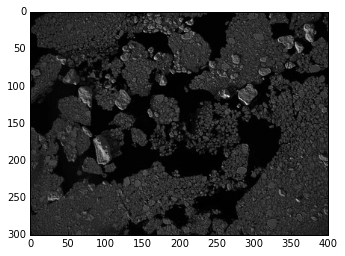

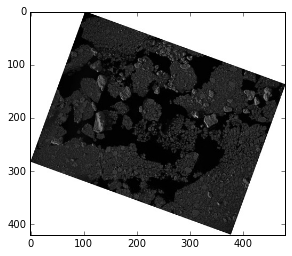

In [57]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 8

img1 = cv2.cvtColor(cv2.imread('dji_0029s.jpg') ,cv2.COLOR_BGR2GRAY)         # queryImage
img2 =  cv2.cvtColor(cv2.imread('dji_0029r.jpg'),cv2.COLOR_BGR2GRAY)  # trainImage
plt.figure()
plt.gray()
plt.imshow(img1)
plt.figure()
plt.imshow(img2)
# Initiate SIFT detector
print(img1.shape, img2.shape)

In [64]:
sift = cv2.ORB()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
print(len(kp1), len(kp2))
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.6*n.distance:
        good.append(m)
print("GOOD MATCHES", len(good))

(483, 500)


error: /Users/jhelmus/anaconda/conda-bld/work/opencv-2.4.8/modules/flann/src/miniflann.cpp:315: error: (-210) type=0
 in function buildIndex_


In [63]:
print(des1.shape, des2.shape)

((875, 128), (987, 128))


[[  9.39588287e-01  -3.41930792e-01   1.03276277e+02]
 [  3.41955022e-01   9.39655731e-01   7.38171885e-01]
 [  3.93790036e-08  -9.49500566e-08   1.00000000e+00]]
(420, 480)


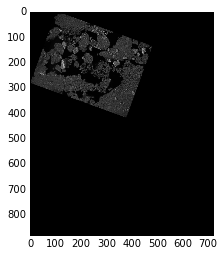

In [62]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

    print(H)
    print(img2.shape)
    ii = cv2.warpPerspective(img1,H,(img1.shape[0]+img2.shape[0],img1.shape[1]+img2.shape[1]))
    plt.imshow(ii)
    #print(mask)
    #h,w = img1.shape
    #pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    #dst = cv2.perspectiveTransform(pts,M)
    #cv2.perspectiveTransform(img1, H)
    #img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, )

else:
    print "Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT)
    matchesMask = None


In [30]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

#img3 = cv2.drawKeypoints(img1,kp1,img2,kp2)

#plt.imshow(img3, 'gray'),plt.show()


In [34]:
print(matches)

[[<DMatch 0x1100cbe50>, <DMatch 0x1100cbcd0>], [<DMatch 0x1100cbf50>, <DMatch 0x11a1050d0>], [<DMatch 0x11a1051b0>, <DMatch 0x11a1052b0>], [<DMatch 0x11a105110>, <DMatch 0x11a105210>], [<DMatch 0x11a1052d0>, <DMatch 0x11a1050f0>], [<DMatch 0x11a1051f0>, <DMatch 0x11a105330>], [<DMatch 0x11a105290>, <DMatch 0x11a105090>], [<DMatch 0x11a105130>, <DMatch 0x11a105230>], [<DMatch 0x11a105370>, <DMatch 0x11a1051d0>], [<DMatch 0x11a105250>, <DMatch 0x11a1050b0>], [<DMatch 0x11a105170>, <DMatch 0x11a105270>], [<DMatch 0x11a1053f0>, <DMatch 0x11a105410>]]


In [65]:
import pickle


In [84]:
ls *.pkl

bad_scale.pkl         good_rotate.pkl       test_rotate.pkl
compare_rotation.pkl  good_scale.pkl        test_scale.pkl


In [293]:
def calc_properties(d, vals, good_or_bad):
    changes = []
    
    for dname in d.keys():
        
        dnamegb = '%s, %s features' %(dname, good_or_bad)
        vals[dnamegb] = {}
        for change in sorted(d[dname].keys()):
            if len(changes) < len(d[dname].keys()):
                changes.append(change)
            for val in sorted(d[dname][change].keys()):
                #print("Comparing", good_or_bad, len(d[dname][change][val]))
                mval = np.mean(d[dname][change][val])
                if mval < 0:
                    mval = 0
                try:
                    
                    vals[dnamegb][val].append(mval)
                except:
                    vals[dnamegb][val] = [mval]
                    #print('change val', val)
                #print(vals, 'on change', change)
               
                #print(val, d[change][val])
                #vals[change]vals.append(np.mean())
    

    return vals, changes

In [365]:

what_changed = 'scale'
g = pickle.load(open('good_%s.pkl' %what_changed))
b = pickle.load(open('bad_%s.pkl'%what_changed))
vals, changes = calc_properties(g, {}, 'good')
vals, c = calc_properties(b, vals, 'bad')
    
print(changes)

[0.5, 0.75, 1.25, 2.0]


('plotting', 'recall')
(0.61102229491252413, 0.0, 0.24440891796500966)
('plotting', 'num_features')
(3209.1999999999998, 0.016666666666666666, 1283.6733333333332)
('plotting', 'precision')
(1.0, 0.0, 0.40000000000000002)
('plotting', 'num_inliers')
(605.39999999999998, 0.0, 242.16)
('plotting', 'time')
(1.3294676780700683, 0.013781249523162842, 0.52627457141876222)
('plotting', 'putative_match_ratio')
(0.61102229491252413, 0.016665000166650002, 0.23774291789834967)
('plotting', 'num_matches')
(605.39999999999998, 0.016666666666666666, 242.15333333333334)


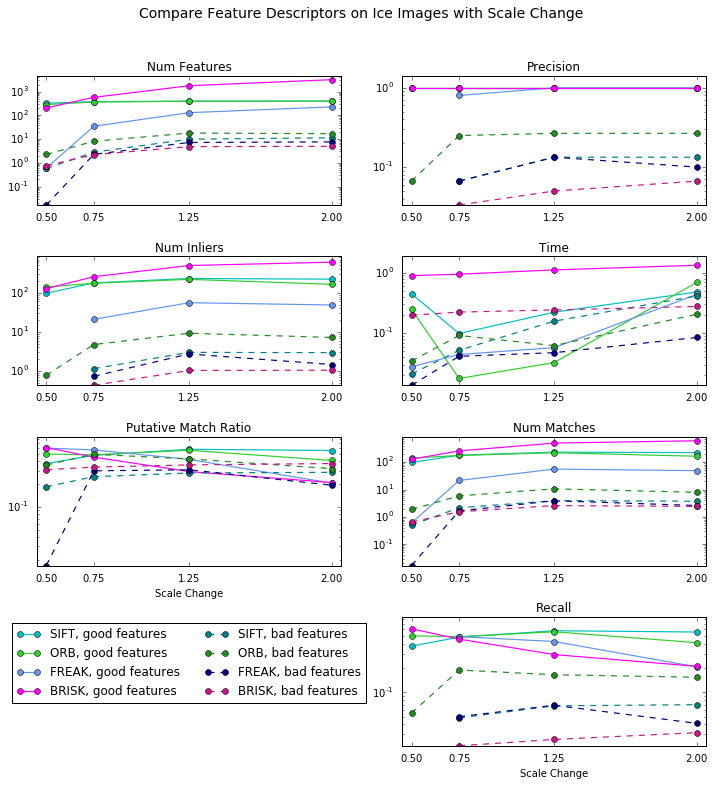

In [369]:

colors = ['c', 'limegreen', 'cornflowerblue', 'magenta',
           'teal','forestgreen',  'navy','mediumvioletred']
order_vals = ['SIFT, good features', 'ORB, good features', 'FREAK, good features', 'BRISK, good features',
              'SIFT, bad features', 'ORB, bad features', 'FREAK, bad features', 'BRISK, bad features']


if what_changed =='rotate':
    say_changed = 'Rotation Change'
    wiggle_x = 1
else:
    say_changed = 'Scale Change'
    wiggle_x = .05
def plot_change(vals, changes, key, what_changed, ax):
    tname = '%s' %(  key.replace('_',' '))
    
    plt.title(tname.title())
    #for xx, dname in enumerate(vals.keys()):
    ymax = -10000
    ymin = 10000
    
    for xx, dname in enumerate(order_vals):
        v = vals[dname][key]
        if 'good' in dname.lower():
            ls = '-'
        else:
            ls = '--'
        if tname.title() in []:
            plt.plot(changes, v, c=colors[xx], linestyle=ls, label=dname, marker='o', linewidth=1.2)
        else:
            plt.semilogy(changes, v, linestyle=ls, c=colors[xx], label=dname, marker='o', linewidth=1.2)
        if min(v) < ymin:
            ymin = min(v)
        if max(v) > ymax:
            ymax = max(v)
    plt.xticks(changes)
    ydiff = (ymax-ymin)*.4
    plt.xlim(xmax=changes[-1]+wiggle_x, xmin=changes[0]-wiggle_x)
    plt.ylim(ymax=ymax+ydiff, ymin=ymin-ydiff)
    print(ymax, ymin, ydiff)
    
    #plt.xlim(xmax=changes[-1]+2)
    #plt.ylabel('%s' %key.replace('_',' '))

vfeats = vals[vals.keys()[0]].keys()
nrows = len(vfeats)/2 + 1
plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=.4)

#fig, ax = plt.subplots(nrows=nrows+1, ncols=2, figsize=(12, 10))

plt.suptitle("Compare Feature Descriptors on Ice Images with %s"%say_changed , fontsize=14)
for xx, vf in enumerate(vfeats):
    print('plotting', vf)
    ax = plt.subplot("%d%d%d" %(nrows,2,xx))
    plot_change(vals, changes, vf, what_changed, ax)

    if xx in [ 5, 0]:
        plt.xlabel("%s" %say_changed)
        

plt.legend(loc=9, bbox_to_anchor=(-.7, -0.4), ncol=2)
plt.savefig('/Users/jhansen/johannah/iceview/doc/figures/%s.png' %(what_changed))
plt.show()

In [ ]:
ax = plt.subplot(111)

for i in xrange(5):
    line, = ax.plot(x, i * x, label='$y = %ix$'%i)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

plt.show()

In [145]:
pa = '/Volumes/johannah_external 1/thesis-work/201511_sea_state_DRI_Sikululiaq/uas_data/seastate_october_21/n2/image_gpx_match.csv'
phpa = os.path.join(os.path.split(pa)[0], 'image')
putpa = os.path.join(phpa, 'bad_photos')
if not os.path.exists(putpa):
    os.mkdir(putpa)

In [170]:
cpd = pd.read_csv(pa)
cpd[cpd.loc[:,'photo'] == 'dsc04593.jpg'] 

,index,photo_datetime,photo,flight,index.1,gpx_datetime,lat,lon,ele,hdg,roll,pitch,filename,pt_idx,sample_name
10,10,2015-10-21 22:22:10,dsc04593.jpg,flight_1,1101,2015-10-21 22:22:12,74.206187,-161.047101,83.24,7.88,-17.69,-10.56,2015-10-22_09-17-57.log.gpx,1101,seastate_october_21


In [148]:
fname = 'flight_1'
min_alt = 75
f = cpd.loc[cpd['flight'] == fname]
#to_move = f.loc[f['ele'] <min_alt]
f = f.loc[f['ele'] >=min_alt]

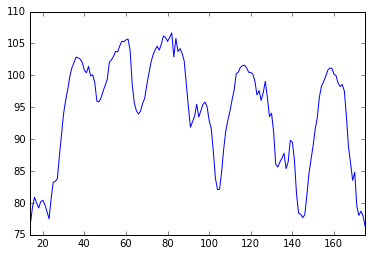

In [142]:
f['ele'].plot()

In [57]:
for p in to_move['photo']:
    ifile = os.path.join(phpa, fname, p)
    if os.path.exists(ifile):
        pfile = os.path.join(putpa, p)
        cmd = ['mv', ifile, pfile]
        #print(cmd)

        p = subprocess.Popen(cmd, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        output, err = p.communicate(b"input data that is passed to subprocess' stdin")
        rc = p.returncode
        #print(output, err, rc)
    

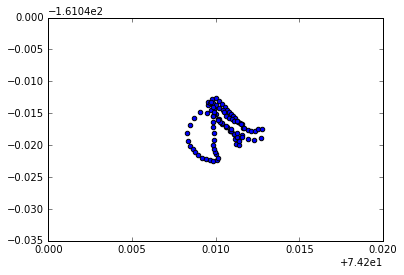

In [58]:
plt.scatter(f['lat'], f['lon'])

In [76]:
f.to_csv( '/Users/jhansen/Desktop/oct_21_flight_1/image_gpx_match.csv', sep=',', index=True, header=True, index_label='index')

In [75]:
for p in f['photo']:
    ifile = os.path.join(phpa, fname, p)
    ofile = os.path.join('/Users/jhansen/Desktop/oct_21_flight_1/%s' % p)
    cmd = ['convert', ifile, '-resize', '600x400', ofile]
    print(' '.join(cmd))
    p = subprocess.Popen(cmd, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, err = p.communicate(b"input data that is passed to subprocess' stdin")
    rc = p.returncode
    print(output, err, rc)
    

convert /Volumes/johannah_external 1/thesis-work/201511_sea_state_DRI_Sikululiaq/uas_data/seastate_october_21/n2/image/flight_1/dsc04583.jpg -resize 600x400 /Users/jhansen/Desktop/oct_21_flight_1/dsc04583.jpg
('', '', 0)
convert /Volumes/johannah_external 1/thesis-work/201511_sea_state_DRI_Sikululiaq/uas_data/seastate_october_21/n2/image/flight_1/dsc04584.jpg -resize 600x400 /Users/jhansen/Desktop/oct_21_flight_1/dsc04584.jpg
('', '', 0)
convert /Volumes/johannah_external 1/thesis-work/201511_sea_state_DRI_Sikululiaq/uas_data/seastate_october_21/n2/image/flight_1/dsc04585.jpg -resize 600x400 /Users/jhansen/Desktop/oct_21_flight_1/dsc04585.jpg
('', '', 0)
convert /Volumes/johannah_external 1/thesis-work/201511_sea_state_DRI_Sikululiaq/uas_data/seastate_october_21/n2/image/flight_1/dsc04586.jpg -resize 600x400 /Users/jhansen/Desktop/oct_21_flight_1/dsc04586.jpg
('', '', 0)
convert /Volumes/johannah_external 1/thesis-work/201511_sea_state_DRI_Sikululiaq/uas_data/seastate_october_21/n2/ima

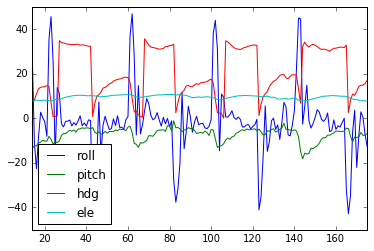

In [114]:
dd = f[['roll', 'pitch', 'hdg', 'ele']]
dd.loc[:,'hdg'] = dd.loc[:,'hdg']/10.0
dd.loc[:,'ele'] = dd.loc[:,'ele']/10.0
dd.plot()

In [102]:
f.columns

Index([u'index', u'photo_datetime', u'photo', u'flight', u'index.1',
       u'gpx_datetime', u'lat', u'lon', u'ele', u'hdg', u'roll', u'pitch',
       u'filename', u'pt_idx', u'sample_name'],
      dtype='object')

In [75]:
aphotos = glob('/Users/jhansen/Desktop/oct_21_flight_1/*.jpg')
photos = [("data/images/%s" %os.path.split(p)[1]) for p in aphotos]
#print(photos)
write_to = open('/Users/jhansen/johannah/js-segment-annotator/data/oct21.json', 'w')
write_to.write("""{
 "labels": [
 "bad",
  "iceberg",
  "mix",
  "slush",
  "ship",
  "cake", 
  "water"  
  ],
 "imageURLs": [
 """)

for p in photos[:-1]:
    write_to.write(' "%s",\n' %p)




write_to.write(''' "%s"
],
"annotationURLs":[\n''' %photos[-1])
for p in range(len(photos[:-1])):
    write_to.write(' "%d.png",\n' %p)
write_to.write(''' "%d.png"
]
}'''%(len(photos)-1))

In [187]:
to_move = f[abs(f['roll']) > 20]

In [190]:

for n in to_move['photo']:
    nn = '/Users/jhansen/Desktop/test_in/%s'%n
    if os.path.exists(nn):
        #os.remove(nn)
        
        print("remove", n)
    else:
        print(n)

('remove', 'dsc04583.jpg')
('remove', 'dsc04585.jpg')
dsc04591.jpg
dsc04592.jpg
dsc04593.jpg
dsc04612.jpg
dsc04613.jpg
dsc04630.jpg
dsc04631.jpg
dsc04632.jpg
dsc04651.jpg
dsc04652.jpg
dsc04653.jpg
dsc04654.jpg
dsc04670.jpg
dsc04671.jpg
dsc04672.jpg
dsc04692.jpg
dsc04693.jpg
dsc04710.jpg
dsc04711.jpg
dsc04712.jpg
dsc04734.jpg
dsc04735.jpg
dsc04736.jpg
dsc04739.jpg


,index,photo_datetime,photo,flight,index.1,gpx_datetime,lat,lon,ele,hdg,roll,pitch,filename,pt_idx,sample_name
7,7,2015-10-21 22:22:04,dsc04590.jpg,flight_1,1061,2015-10-21 22:22:04,74.206068,-161.048077,79.72,145.92,-8.09,-10.27,2015-10-22_09-17-57.log.gpx,1061,seastate_october_21


In [150]:
f[f.loc[:,'photo'] == 'dsc04591.jpg'] 

,index,photo_datetime,photo,flight,index.1,gpx_datetime,lat,lon,ele,hdg,roll,pitch,filename,pt_idx,sample_name
8,8,2015-10-21 22:22:06,dsc04591.jpg,flight_1,1071,2015-10-21 22:22:06,74.205884,-161.047393,78.66,142.15,35.18,-8.12,2015-10-22_09-17-57.log.gpx,1071,seastate_october_21


In [42]:
aa = '/Users/jhansen/johannah/js-segment-annotator/data/annotations/2.png'

In [43]:
a = cv2.imread(aa, cv2.IMREAD_UNCHANGED)

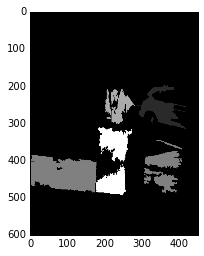

In [44]:
plt.figure()
plt.gray()
plt.imshow(a[:,:,2])

In [30]:
a.shape

(600, 450, 4)

In [28]:
np.max(a)

255